<a href="https://colab.research.google.com/github/javicivit/TPU-UNET/blob/master/TPU_UNET_CD_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Training of a modified U-Net for Optic Disc/Cup on RIM-ONE v3  & DRISHTI databases.

We use publicly available RIM-ONE v3, DRISHTI and DRIONS datasets. 

### Training of a modified U-Net for Optic Disc/Cup on RIM-ONE v3  & DRISHTI databases.

We use publicly available RIM-ONE v3, DRISHTI and DRIONS datasets. The use of multiple datasets both for training and for validation allows our system to be more independent of the capture devices than other available implementations. RIM ONE-v3, from the MIAG group of the University of La Laguna (Spain), consists of 159 fundus images which have been labeled by expert ophthalmologists for both disc and cup. DRISHTI-GS, from Aravind Eye hospital, Madurai, India consists of 101 fundus images also labeled for disc and cup. DRIONS-DB from Miguel Servet Hospital, Saragossa (Spain), consists of 110 images on which only the optic cup has been labelled.
Fundus images and disk maskks are resized in one sted to 128x128.  The hdf versions of the Datasets can be uploaded from [Sevastopolsky's github](https://github.com/seva100/optic-nerve-cnn)


# Train with RIM one and DRISHTI
## GPU based UNET Segmentation.




####Lets load the data from Gdrive


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#CONFIGURATION
name='MIXCUPT6w64ir11r42'
train=True
Epochs=30
preload=False
pname='MIXCUPSQ6w64ir11r42'
hough=False
rams=False
dynAug=False


In [0]:
def seperate_string_number(string):
    previous_character = string[0]
    groups = []
    newword = string[0]
    for x, i in enumerate(string[1:]):
        if i.isalpha() and previous_character.isalpha():
            newword += i
        elif i.isnumeric() and previous_character.isnumeric():
            newword += i
        else:
            groups.append(newword)
            newword = i

        previous_character = i

        if x == len(string) - 2:
            groups.append(newword)
            newword = ''
    return groups


In [0]:
conf=seperate_string_number(name)
depth=int(conf[1])
chan=int(conf[3])
ir=int(conf[5])/10.0
rand_sv=int(conf[7])
ds=conf[0][0:3]
zone=conf[0][3:6]

In [6]:
print(depth,chan,ir,rand_sv,ds,zone)

6 64 1.1 42 MIX CUP


In [0]:
if(zone=='CUP'):
  cup=True
else:
  cup=False

In [0]:
mix=False
dri=False
rim=False
if(ds=='MIX'):
  mix=True
elif(ds=='DRI'):
  dri=True
elif(ds=='RIM'):
  rim=True
else:
  breakpoint


In [0]:
#!pip install --upgrade tensorflow==2.2.0-rc3

Let's import the required libraries:

In [0]:

import tensorflow as tf


import os
import glob
from datetime import datetime
#import warnings
#warnings.simplefilter('ignore')
import scipy as sp
import scipy.ndimage
import numpy as np
import pandas as pd
import skimage
import skimage.exposure
import skimage.transform
import skimage.measure
#from sklearn.cross_validation import KFold
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import h5py
from tqdm import tqdm_notebook
#import mahotas as mh
from IPython.display import display
#from dual_IDG import DualImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers as layers
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, \
    Conv2D, MaxPooling2D, ZeroPadding2D, Input, Embedding, LSTM,  \
    Lambda, UpSampling2D,concatenate,Conv2DTranspose
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import SGD, Adam, Adagrad
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import math
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter, ellipse
from skimage.measure import  ransac, EllipseModel

In [11]:
print("Tensorflow version " + tf.__version__)
if 'COLAB_TPU_ADDR'  in os.environ:
    print(os.environ['COLAB_TPU_ADDR'])
else:
  print('No TPU')
if(tf.test.is_gpu_available()):
  gpu=True
else:
  gpu=False
  print('No GPU')

Tensorflow version 2.2.0
10.90.122.250:8470
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
No GPU


Our loss function is based on dice (intersectionover union).
We use -log(dice) as our loss function 

In [0]:

K.set_floatx('float32')

In [0]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())
  
def dice_loss(y_true,y_pred):
    return -dice_coef(y_true,y_pred)
  
def log_dice_loss(y_true, y_pred):
    return -K.log(dice_coef(y_true, y_pred))

In [0]:
def iou_loss_core(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true,-1) + K.sum(y_pred,-1) - intersection
    iou = (intersection + smooth) / ( union + smooth)
    return iou

Auxiliary function to modify image brightness.

In [0]:
def modify_brightness_p(img, p=1.2):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 1.0/p
    v[v > lim] = 1.0
    v[v <= lim] *= p
    #print(np.amax(v))

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR).clip(min=0)
    return img

Auxiliary funtion to shuffle to vectors in a coherent way:

In [0]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

Auxiliary function to use 512 image size indexes with original images.

In [0]:
def index512_resize(index,top):
  index=index*top/512
  return int(index)

Function to convert Image set into ellipses removing extra zones also

Our data is in hdf5 (https://www.h5py.org/) format
Train/test with  Drishti and RimONE

In [0]:
h5f1 = h5py.File(os.path.join(os.path.dirname(os.getcwd()), 'content/gdrive/My Drive', 'RIM_ONE_v3.hdf5'), 'r')

In [0]:
h5f2=h5py.File(os.path.join(os.path.dirname(os.getcwd()), 'content/gdrive/My Drive', 'DRISHTI_GS.hdf5'), 'r')

In [0]:
h5v1=h5py.File(os.path.join(os.path.dirname(os.getcwd()), 'content/gdrive/My Drive', 'DRIONS_DB.hdf5'), 'r')

### U-Net architecture


In [0]:
'''
U-Net: Convolutional Networks for Biomedical Image Segmentation
(https://arxiv.org/abs/1505.04597)
---
img_shape: (height, width, channels)
out_ch: number of output channels
start_ch: number of channels of the first conv
depth: zero indexed depth of the U-structure
inc_rate: rate at which the conv channels will increase
activation: activation function after convolutions
dropout: amount of dropout in the contracting part
batchnorm: adds Batch Normalization if true
maxpool: use strided conv instead of maxpooling if false
upconv: use transposed conv instead of upsamping + conv if false
residual: add residual connections around each conv block if true
'''

def conv_block(m, dim, acti, bn, res, do=0):
	n = Conv2D(dim, 3, activation=acti, padding='same')(m)
	n = BatchNormalization()(n) if bn else n
	n = Dropout(do)(n) if do else n
	n = Conv2D(dim, 3, activation=acti, padding='same')(n)
	n = BatchNormalization()(n) if bn else n
	return Concatenate()([m, n]) if res else n

def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
	if depth > 0:
		n = conv_block(m, dim, acti, bn, res)
		m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
		m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res)
		if up:
			m = UpSampling2D()(m)
			m = Conv2D(dim, 2, activation=acti, padding='same')(m)
		else:
			m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
		n = concatenate([n, m],axis=-1)
		m = conv_block(n, dim, acti, bn, res)
	else:
		m = conv_block(m, dim, acti, bn, res, do)
	return m

def UNet(img_shape, out_ch=1, start_ch=64, depth=4, inc_rate=2., activation='relu', 
		 dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=False):
	i = Input(shape=img_shape)
	o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
	o = Conv2D(out_ch, 1, activation='sigmoid')(o)
	return Model(inputs=i, outputs=o)


Change these parameters according to  the architecture . Uss Cup=True to segment the Cup and False to segment the disk.

In [0]:
img_shape=(128,128,3)

**DRISHTI RIM ONE CUP Aggressive augmentation**

Accessing data, preparing train/validation sets: Resize & Prepare

In [23]:
Xori= np.asarray(h5f2['DRISHTI-GS/orig/images'])
#print(Xori.shape)
disc_locations =np.asarray( h5f2['DRISHTI-GS/512 px/disc_locations'])
#Glau=h5f2['DRISHTI-GS/orig/is-ill']  #Has Glaucoma?
FC=np.asarray(h5f2['DRISHTI-GS/512 px/file_codes'] )  #FC
indDRI=np.arange(0,Xori.shape[0])
bsqside=np.maximum((disc_locations[:,3]-disc_locations[:,1]),(disc_locations[:,2]-disc_locations[:,0]))

isize=Xori.shape[1]

if(cup):
  #md=(np.amin(disc_locations[:])/8).astype(np.int)
  
  Yf = np.asarray(h5f2['DRISHTI-GS/512 px/cup'])
 
  Xc = [Xori[i][index512_resize(disc_locations[i][0],isize):index512_resize(disc_locations[i][0]+bsqside[i],isize), index512_resize(disc_locations[i][1],isize):index512_resize(disc_locations[i][1]+bsqside[i],isize)] 
                   for i in range(len(Xori))]

  Yc=[Yf[i][disc_locations[i][0]:disc_locations[i][0]+bsqside[i], disc_locations[i][1]:disc_locations[i][1]+bsqside[i]] 
                   for i in range(len(Xori))]
else:
  Yf =np.asarray( h5f2['DRISHTI-GS/512 px/disc'])
  
  Xc = [Xori[i][index512_resize(50,isize):index512_resize(462,isize), index512_resize(50,isize):index512_resize(462,isize)] 
                   for i in range(len(Xori))]

  Yc=[Yf[i][50:462,50:462] 
                   for i in range(len(Xori))]

X=[cv2.resize(img, (128, 128),interpolation=cv2.INTER_NEAREST) for img in Xc]
#X=[skimage.exposure.equalize_adapthist(img, clip_limit=0.035)  for img in Xa]
X=np.asarray(X) 
am=np.amax(X)
X=X.astype(np.float32)/am 
print(np.amax(X),np.amin(X))

Y=[cv2.resize(img, (128, 128),interpolation=cv2.INTER_NEAREST)[..., None] for img in Yc]
Y=np.asarray(Y) 
ym=np.amax(Y) 
Yf=Y/ym 
Yb=(Y>0.5).astype(np.float32) #get binary mask


print(np.amax(Yf),np.amin(Yf))
print(X.shape)

1.0 0.0
1.0 0.0
(50, 128, 128, 3)


In [24]:
Xvori= h5f1['RIM-ONE v3/orig/images']
disc_locationsv = h5f1['RIM-ONE v3/512 px/disc_locations']
Glauv=np.asarray(h5f1['RIM-ONE v3/512 px/is_ill'] ) #Has Glaucoma?
FCv=np.asarray(h5f1['RIM-ONE v3/512 px/file_codes'])   #FC
indRIM=np.arange(0,Xvori.shape[0])
bsqsidev=np.maximum((disc_locationsv[:,3]-disc_locationsv[:,1]),(disc_locationsv[:,2]-disc_locationsv[:,0]))


low_cont_n=0;
ivsize=Xvori.shape[1]
if (cup):
  Yvf = h5f1['RIM-ONE v3/512 px/cup']
  Xvc = [Xvori[i][index512_resize(disc_locationsv[i][0],ivsize):index512_resize(disc_locationsv[i][0]+bsqsidev[i],ivsize), index512_resize(disc_locationsv[i][1],ivsize):index512_resize(disc_locationsv[i][1]+bsqsidev[i],ivsize)] 
                     for i in range(len(Xvori))]

  Yvc=[Yvf[i][disc_locationsv[i][0]:disc_locationsv[i][0]+bsqsidev[i], disc_locationsv[i][1]:disc_locationsv[i][1]+bsqsidev[i]] 
                     for i in range(len(Xvori))]

else:
  Yvf = h5f1['RIM-ONE v3/512 px/disc']
  Xvc = [Xvori[i][index512_resize(50,isize):index512_resize(462,ivsize), index512_resize(50,isize):index512_resize(462,ivsize)] 
                     for i in range(len(Xvori))]

  Yvc=[Yvf[i][50:462,50:462] 
                     for i in range(len(Xvori))]


Xvn=[cv2.resize(img, (128, 128),interpolation=cv2.INTER_NEAREST) for img in Xvc]
#Xv=[skimage.exposure.equalize_adapthist(img, clip_limit=0.035)  for img in Xvn]

Xv=np.asarray(Xvn) 
am=np.amax(Xv)
Xv=Xv.astype(np.float32)/am 
print(np.amax(Xv),np.amin(Xv))

#find number of low contrast images
for img in Xv:
  if(skimage.exposure.is_low_contrast(img,fraction_threshold=0.2)):
    low_cont_n=low_cont_n+1

print('low contrast#= {}'.format(low_cont_n))

Yv=[cv2.resize(img, (128, 128),interpolation=cv2.INTER_NEAREST)[..., None] for img in Yvc]

Yv=np.asarray(Yv) 
ym=np.amax(Yv) 
Yvf=(Yv/ym).astype(np.float32) 
print(np.amax(Yvf),np.amin(Yvf))
print(Xv.shape)

1.0 0.0
low contrast#= 36
1.0 0.0
(159, 128, 128, 3)


Create more "data". Just copy the vectors over themselves and add modified versions so that the generators can  produce longer batches & Distibute between train & test

In [25]:
rng = np.random.RandomState(rand_sv)

#DRI
X_train1t, X_test1t, Y_train1t, Y_test1t,   F_train1t, F_test1t ,ind_train1, ind_test1= train_test_split( X, Yb, FC, indDRI,test_size=0.25,random_state=rng)

#RIM
X_train2, X_test2, Y_train2, Y_test2, G_train2, G_test2, F_train2, F_test2, ind_train2, ind_test2= train_test_split( Xv, Yvf,Glauv, FCv,indRIM, test_size=0.25,random_state=rng)

X_test_dri=np.copy(X_test1t)
Y_test_dri=np.copy(Y_test1t)
#G_test_dri=np.copy(G_test1t)
F_test_dri=np.copy(F_test1t)

X_test_rim=np.copy(X_test2)
Y_test_rim=np.copy(Y_test2)
G_test_rim=np.copy(G_test2)
F_test_rim=np.copy(F_test2)

if(dri or mix):
  X_train1=np.concatenate([X_train1t,X_train1t])
  X_train1=np.concatenate([X_train1,X_train1t])
  X_test1=np.concatenate([X_test1t,X_test1t])
  X_test1=np.concatenate([X_test1,X_test1t])

  Y_train1=np.concatenate([Y_train1t,Y_train1t])
  Y_train1=np.concatenate([Y_train1,Y_train1t])
  Y_test1=np.concatenate([Y_test1t,Y_test1t])
  Y_test1=np.concatenate([Y_test1,Y_test1t])

if(mix):
  X_train1=np.concatenate([X_train1,X_train2])
  Y_train1=np.concatenate([Y_train1,Y_train2])
  X_test1=np.concatenate([X_test1,X_test2])
  Y_test1=np.concatenate([Y_test1,Y_test2])

  X_train1=np.concatenate([X_train1,X_train2])
  Y_train1=np.concatenate([Y_train1,Y_train2])
  X_test1=np.concatenate([X_test1,X_test2])
  Y_test1=np.concatenate([Y_test1,Y_test2])

if(rim):
  X_train1=np.concatenate([X_train2,X_train2])
  #X_train1=np.concatenate([X_train1,X_train2])
  X_test1=np.concatenate([X_test2,X_test2])
  #X_test1=np.concatenate([X_test1,X_test2])

  Y_train1=np.concatenate([Y_train2,Y_train2])
  #Y_train1=np.concatenate([Y_train1,Y_train2])
  Y_test1=np.concatenate([Y_test2,Y_test2])
  #Y_test1=np.concatenate([Y_test1,Y_test2])

if(dri):
  X_train1=np.concatenate([X_train1,X_train1])
  Y_train1=np.concatenate([Y_train1,Y_train1])

X_train1=np.asarray(X_train1)
Y_train1=np.asarray(Y_train1)
X_test=np.asarray(X_test1)
Y_test=np.asarray(Y_test1)

X_train=np.copy(X_train1)
Y_train=np.copy(Y_train1)

size=X_train1.shape[0]

X_traine=np.empty((20*size, 128, 128, 3),dtype=np.float32)
Y_traine=np.empty((20*size, 128, 128, 1),dtype=np.float32)



for i in range(16):
  #print(i*size,(i+1)*size)
  X_traine[i*size:(i+1)*size]=X_train1
  Y_traine[i*size:(i+1)*size]=Y_train1
  
base= 16*size

for j in tqdm_notebook(range(X_train1.shape[0])):
  X_traine[base]=skimage.exposure.equalize_adapthist(X_train1[j], clip_limit=0.04)
  Y_traine[base]=Y_train1[j]
  base+=1
  X_traine[base]=skimage.exposure.equalize_adapthist(X_train1[j], clip_limit=0.02)
  Y_traine[base]=Y_train1[j]
  base+=1
  X_traine[base]=modify_brightness_p(X_train1[j],0.9)
  Y_traine[base]=Y_train1[j]
  base+=1
  X_traine[base]=modify_brightness_p(X_train1[j],1.1)
  Y_traine[base]=Y_train1[j]
  base+=1
  
X_testc=np.copy(X_test)
Y_testc=np.copy(Y_test)

sizev=X_testc.shape[0]

X_teste=np.empty((20*sizev, 128, 128, 3),dtype=np.float32)
Y_teste=np.empty((20*sizev, 128, 128, 1),dtype=np.float32)

for i in range(8):
  X_teste[i*sizev:(i+1)*sizev]=X_testc
  Y_teste[i*sizev:(i+1)*sizev]=Y_testc
  
basev= 8*sizev

for j in tqdm_notebook(range(X_testc.shape[0])):
  X_teste[basev]=skimage.exposure.equalize_adapthist(X_testc[j], clip_limit=0.04)
  Y_teste[basev]=Y_testc[j]
  basev+=1
  X_teste[basev]=skimage.exposure.equalize_adapthist(X_testc[j], clip_limit=0.02)
  Y_teste[basev]=Y_testc[j]
  basev+=1
  X_teste[basev]=modify_brightness_p(X_testc[j],0.9)
  Y_teste[basev]=Y_testc[j]
  basev+=1
  X_teste[basev]=modify_brightness_p(X_testc[j],1.1)
  Y_teste[basev]=Y_testc[j]
  basev+=1
  
 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:106: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


***Aumented dual image generator***


In [0]:
X_trains,Y_trains=unison_shuffled_copies(X_traine, Y_traine)

In [0]:
X_tests,Y_tests=unison_shuffled_copies(X_teste, Y_teste)

In [0]:
# Provide the same seed and keyword arguments to the fit and flow methods
seed=rand_sv
batch_s=120
#batch_s=96 #conv_Trans will not run in GPU with 128

In [0]:
data_gen_args = dict(#rescale=1./255,
                     #featurewise_center=True,
                     #featurewise_std_normalization=True,
                     horizontal_flip=True, vertical_flip=True,
                     rotation_range=30,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2,
                     fill_mode='constant', cval=0.0, 
                     #brightness_range=[-0.1,0.1],
                     #preprocessing_function=skimage.exposure.equalize_adapthist,
                     dtype='float32'
                     )

data_gen_args_test = dict(#rescale=1./255,
                     #featurewise_center=True,
                     #featurewise_std_normalization=True,
                     horizontal_flip=False, vertical_flip=False,
                     rotation_range=0,
                     width_shift_range=0,
                     height_shift_range=0,
                     zoom_range=0,
                     fill_mode='constant', cval=0.0, 
                     #brightness_range=[-0.1,0.1],
                     #preprocessing_function=skimage.exposure.equalize_adapthist,
                     dtype='float32'
                     )


image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

image_generator = image_datagen.flow(
    X_trains,
    batch_size=batch_s,
    seed=seed)

mask_generator = mask_datagen.flow(
    Y_trains,
    batch_size=batch_s,
    seed=seed)

#train_generator = zip(image_generator, mask_generator)
def train_generator():
  while True:
    yield image_generator.next(),mask_generator.next()
    
#Lets try not to alter the test data

image_datagenT = ImageDataGenerator(**data_gen_args_test)
mask_datagenT = ImageDataGenerator(**data_gen_args_test)

image_generator_test = image_datagenT.flow(
    X_tests,
    batch_size=batch_s,
    seed=seed)

mask_generator_test = mask_datagenT.flow(
    Y_tests,
    batch_size=batch_s,
    seed=seed)

#test_generator = zip(image_generator_test, mask_generator_test)
def test_generator():
  while True:
    yield image_generator_test.next(),mask_generator_test.next()

In [0]:
train_dataset = tf.data.Dataset.from_generator(train_generator, (tf.float32, tf.float32),((None,128,128,3),(None,128,128,1)))

In [0]:
test_dataset = tf.data.Dataset.from_generator(test_generator, (tf.float32, tf.float32),((None,128,128,3),(None,128,128,1)))

Set the place for localy saving the weights. After training we will copy to Gdrive

###Train on GPU

In [0]:
cp_callbacks = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join('/content/gdrive/My Drive/TPU/'+name+'last_checkpoint.hdf5'), verbose=1, save_best_only=True,save_weights_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, min_lr=2e-4)

In [33]:

if 'COLAB_TPU_ADDR' not in  os.environ:
  if (gpu):
    strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
  else:
    strategy = tf.distribute.OneDeviceStrategy(device="/cpu:0")
else:
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
  tf.config.experimental_connect_to_cluster(resolver)
  tf.tpu.experimental.initialize_tpu_system(resolver)
  strategy = tf.distribute.experimental.TPUStrategy(resolver)

with strategy.scope():
  #model = create_model()
  model = UNet(img_shape,start_ch=chan,upconv=False,dropout=0.5, depth=depth,inc_rate=ir, batchnorm=True) #create_model()
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=.001, ),
      #loss='binary_crossentropy',metrics=['accuracy'],
      loss=log_dice_loss, metrics=[dice_coef]
      )

INFO:tensorflow:Initializing the TPU system: grpc://10.90.122.250:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.90.122.250:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [0]:
if(preload):
  model.load_weights(os.path.join('/content/gdrive/My Drive/TPU/'+pname+'last_checkpoint.hdf5'))

In [35]:


if(train):
  history=model.fit(
    #x_train.astype(np.float32), y_train.astype(np.float32),
    #train_dataset,
    X_trains,Y_trains,
    epochs=Epochs,
    batch_size=128,
    steps_per_epoch=35,
    validation_data = (X_tests,Y_tests),
    #validation_steps=8,
    callbacks=[cp_callbacks,reduce_lr],
    verbose=1
  )

model.save_weights(os.path.join('/content/gdrive/My Drive/TPU/'+name+'F_last_checkpoint.hdf5'), overwrite=True)

Epoch 1/30
35/35 [==============================] - ETA: 0s - dice_coef: 0.6974 - loss: 0.3866
Epoch 00001: val_loss improved from inf to 1.02489, saving model to /content/gdrive/My Drive/TPU/MIXCUPT6w64ir11r42last_checkpoint.hdf5
35/35 [==============================] - 24s 676ms/step - dice_coef: 0.6974 - loss: 0.3866 - val_dice_coef: 0.3685 - val_loss: 1.0249 - lr: 0.0010
Epoch 2/30
35/35 [==============================] - ETA: 0s - dice_coef: 0.8783 - loss: 0.1304
Epoch 00002: val_loss improved from 1.02489 to 0.57167, saving model to /content/gdrive/My Drive/TPU/MIXCUPT6w64ir11r42last_checkpoint.hdf5
35/35 [==============================] - 22s 628ms/step - dice_coef: 0.8783 - loss: 0.1304 - val_dice_coef: 0.5676 - val_loss: 0.5717 - lr: 0.0010
Epoch 3/30
35/35 [==============================] - ETA: 0s - dice_coef: 0.9259 - loss: 0.0773
Epoch 00003: val_loss did not improve from 0.57167
35/35 [==============================] - 10s 298ms/step - dice_coef: 0.9259 - loss: 0.0773 - v

In [0]:
if(train):
  model.load_weights(os.path.join('/content/gdrive/My Drive/TPU/'+name+'last_checkpoint.hdf5'))


In [37]:
model.evaluate(X_tests[0:768,:,:,:],Y_tests[0:768,:,:,:])

24/24 [==============================] - 0s 17ms/step - dice_coef: 0.8349 - loss: 0.4781


[0.47805655002593994, 0.8348942995071411]

Save weights on Gdrive. Ajust destination File as desired

**Chart Accuracy and Loss**

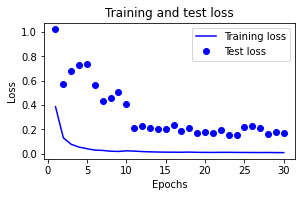

In [38]:
if(train):
  loss = history.history['loss']
  val_loss=history.history['val_loss']
  acc=history.history['dice_coef']

  epochs = range(1, len(loss) + 1)

  plt.figure(figsize=(4.5, 2.5))
  plt.plot(epochs, loss, 'b', label='Training loss')
  # bo is blue dots
  plt.plot(epochs, val_loss, 'bo', label='Test loss')
  # b is for "solid blue line"
  plt.title('Training and test loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  #plt.show()
  plt.savefig(os.path.join('/content/gdrive/My Drive/FIG','loss'+name+'.png'),dpi=600)


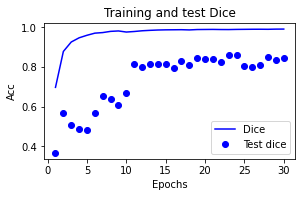

In [39]:
if(train):
  loss = history.history['loss']
  acc=history.history['dice_coef']
  val_acc=history.history['val_dice_coef']

  epochs = range(1, len(acc) + 1)

  plt.figure(figsize=(4.5, 2.5))
  plt.plot(epochs, acc, 'b', label='Dice')
  # bo is blue dots
  plt.plot(epochs, val_acc, 'bo', label='Test dice')
  # b is for "solid blue line"
  plt.title('Training and test Dice')
  plt.xlabel('Epochs')
  plt.ylabel('Acc')
  plt.legend()

  #plt.show()
  plt.savefig(os.path.join('/content/gdrive/My Drive/FIG','hist'+name+'.png'),dpi=600)

### Comprehensive visual check

In [40]:
test_s=int(X_testc.shape[0])
test_s=test_s-test_s%8
test_s

112

In [0]:
smooth=1e-07

def np_dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return ( (2. * intersection + smooth) / 
             (np.sum(y_true_f) + np.sum(y_pred_f) + smooth) )

In [0]:
def np_iou(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return ( ( intersection + smooth) / 
             (np.sum(y_true_f) + np.sum(y_pred_f) - intersection + smooth) )
  
  
  
    

Acquiring scores for the validation set:

In [0]:
from skimage.morphology import erosion, dilation, opening, closing, white_tophat

In [0]:
from skimage.feature import canny
from skimage import color

In [45]:
X_testc.shape

(119, 128, 128, 3)

(112, 128, 128, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()



Dice mean= 0.84778196  Std= 0.08937031  best= 0.9663544  worst= 0.61766887
IOU mean= 0.74562347  Std= 0.12738493  best= 0.9348992  worst= 0.44683138
image #12
0.9663544
image #3
0.61766887
CPU times: user 5.75 s, sys: 90.7 ms, total: 5.84 s
Wall time: 11.6 s


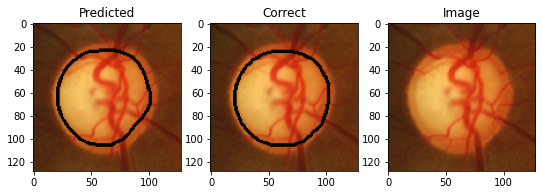

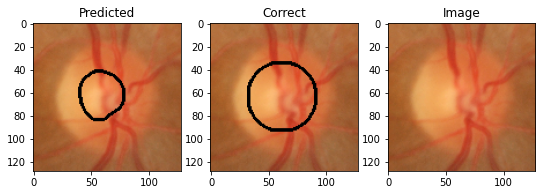

In [46]:
%%time
pred_dice=np.empty((test_s), dtype=np.float32)
pred_iou=np.empty((test_s), dtype=np.float32)


#sess = K.get_session()

batch_X = X_testc[0:test_s]
batch_y = Y_testc[0:test_s]
print (batch_X.shape)
    
predv = (model.predict(batch_X,batch_size=test_s)[...,0]>0.5).astype(np.float32)
corrv= (batch_y)[ ..., 0].astype(np.float32)
predv1=predv.copy()


for i in tqdm_notebook(range(predv.shape[0])):
    #print('image #{}'.format(i))
    img = X_test[i]
    
    pred = predv[i]
    corr = corrv[i]
    label_pc = skimage.measure.label(pred, connectivity=pred.ndim)
    props_pc = skimage.measure.regionprops(label_pc)
    sz=len(props_pc)
    if(sz)!=0:
      areap=[props_pc[i].area for i in range(sz)]
      k=np.argmax(areap)
      #print(k,areap)
      predv1[i]=np.equal(label_pc,k+1).astype(int).astype(np.float32)
    pred1= predv1[i]
    cur_dice = np_dice_coef(pred1, corr)
    cur_iou = np_iou(pred1,corr)
    #print(cur_dice)
    pred_dice[i]=(cur_dice)
    pred_iou[i]=cur_iou
    
    
d_worst=np.amin(pred_dice)
d_best=np.amax(pred_dice)
d_mean=np.mean(pred_dice)
d_std=np.std(pred_dice)
print("Dice mean=",d_mean, " Std=",d_std, " best=",d_best," worst=",d_worst)

i_worst=np.amin(pred_iou)
i_best=np.amax(pred_iou)
i_mean=np.mean(pred_iou)
i_std=np.std(pred_iou)
print("IOU mean=",i_mean, " Std=",i_std, " best=",i_best," worst=",i_worst)

ix_best=np.argmax(pred_dice)
ix_worst=np.argmin(pred_dice)

j=0
for i in [ix_best,ix_worst]:
    print('image #{}'.format(i))
    img = X_test[i]
    pred1 = predv1[i]
    corr = corrv[i]
    
    print(pred_dice[i])
    fig = plt.figure(figsize=(9, 4))
    ax = fig.add_subplot(1, 3, 1)
    edgesp = canny(pred1)
    edgesp=1.0-dilation(edgesp)
    edgesp = color.gray2rgb(1.0*edgesp)
    ax.imshow(img*edgesp)
    ax.set_title('Predicted')
    ax = fig.add_subplot(1, 3, 2)
    edgesc = canny(corr)
    edgesc=1.0-dilation(edgesc)
    edgesc = color.gray2rgb(1.0*edgesc)
    ax.imshow(img*edgesc)
    ax.set_title('Correct')
    ax = fig.add_subplot(1, 3, 3)
    #ax.imshow(img)
    ax.imshow(img)
    ax.set_title('Image')
    #plt.show()
    fig.savefig(os.path.join('/content/gdrive/My Drive/FIG','img'+str(j)+name+'.png'),dpi=600)
    j+=1
    


In [47]:
%%time

batch_X = X_testc[0:test_s]
batch_y = Y_testc[0:test_s]
print (batch_X.shape)
    
predv = (model.predict(batch_X,batch_size=test_s)[...,0]>0.5).astype(np.float32)
corrv= (batch_y)[ ..., 0].astype(np.float32)

(112, 128, 128, 3)
CPU times: user 247 ms, sys: 33.4 ms, total: 280 ms
Wall time: 554 ms


In [48]:
cup_rr= np.empty((test_s), dtype=np.float32)
cup_dc= np.empty((test_s), dtype=np.float32)
cup_ac= np.empty((test_s), dtype=np.float32)
cup_ap= np.empty((test_s), dtype=np.float32)


predc = predv[0, ...].copy()
predv1 = predv[...].copy()
corrc= corrv[0, ...].copy()
print (predc.shape)

for i in tqdm_notebook(range(test_s), leave=True):
    
    predc = predv[i]
    corrc = corrv[i]
    
    label_pc = skimage.measure.label(predc, connectivity=predc.ndim)
    props_pc = skimage.measure.regionprops(label_pc)
    
    label_cc = skimage.measure.label(corrc, connectivity=corrc.ndim)
    props_cc = skimage.measure.regionprops(label_cc)
    
    sz=len(props_pc)
    if(sz)!=0:
      areap=[props_pc[i].area for i in range(sz)]
      
      k=np.argmax(areap)
      #print(k,areap)
      predv1[i]=np.equal(label_pc,k+1).astype(int).astype(np.float32)
    
      xcp = props_pc[k].centroid[0] #x center
      ycp = props_pc[k].centroid[1] #y_center
      ap = props_pc[k].area
    else:
      xpc=0
      ypc=0
      ac=0
    
    xcc = props_cc[0].centroid[0] #x center
    ycc = props_cc[0].centroid[1] #y_center
    ac = props_cc[0].area


    
    if (ap>ac):
      ar=ac/ap
    else:
      ar=ap/ac
      
    dist=math.sqrt((xcp-xcc)*(xcp-xcc)+(ycp-ycc)*(ycp-ycc))
    cup_rr[i]=math.sqrt(ar)
    cup_dc[i]=dist
    cup_ac[i]=ac
    cup_ap[i]=ap

(128, 128)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


In [49]:
#print(cup_rr)
#print(cup_dc)
print('best radii ratio= {:0.2f}, worst radii ratio= {:0.2f}, worst center distance= {:0.2f}, best center distance= {:0.2f}'.format(np.amax(cup_rr),np.amin(cup_rr),np.amax(cup_dc),np.amin(cup_dc)))
bt90=cup_rr>.9
print('Percentage of images with less than 10% radius error ={:0.2f}'.format(sum(bt90)/test_s))

best radii ratio= 1.00, worst radii ratio= 0.64, worst center distance= 8.84, best center distance= 0.24
Percentage of images with less than 10% radius error =0.44




###Validation RIM

In [50]:
test_s=int(X_test_rim.shape[0])
#test_s=test_s-test_s%8
test_s

40

(40, 128, 128, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()



Dice mean= 0.8264328  Std= 0.08694417  best= 0.9652579  worst= 0.61906695
IOU mean= 0.71324855  Std= 0.12244753  best= 0.93284875  worst= 0.44829613
image #37
0.9652579
image #5
0.61906695


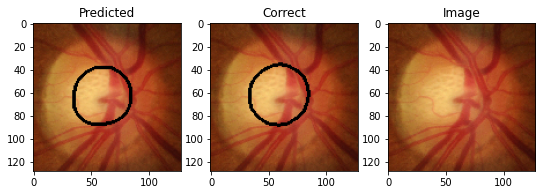

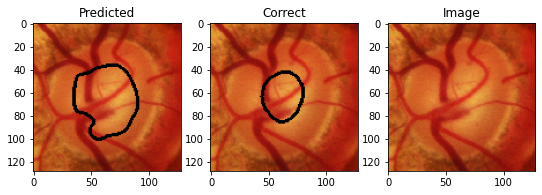

In [51]:

pred_dice=np.empty((test_s), dtype=np.float32)
pred_iou=np.empty((test_s), dtype=np.float32)


#sess = K.get_session()

batch_X = X_test_rim[0:test_s]
batch_y = Y_test_rim[0:test_s]
print (batch_X.shape)
    
predv = (model.predict(batch_X,batch_size=test_s)[...,0]>0.5).astype(np.float32)
corrv= (batch_y)[ ..., 0].astype(np.float32)
predv1=predv.copy()

for i in tqdm_notebook(range(predv.shape[0])):
    #print('image #{}'.format(i))
    img = X_test_rim[i]
    
    pred = predv[i]
    corr = corrv[i]
    label_pc = skimage.measure.label(pred, connectivity=pred.ndim)
    props_pc = skimage.measure.regionprops(label_pc)
    sz=len(props_pc)
    if(sz)!=0:
      areap=[props_pc[i].area for i in range(sz)]
      k=np.argmax(areap)
      #print(k,areap)
      predv1[i]=np.equal(label_pc,k+1).astype(int).astype(np.float32)
    pred1= predv1[i]
    cur_dice = np_dice_coef(pred1, corr)
    cur_iou = np_iou(pred1,corr)
    #print(cur_dice)
    pred_dice[i]=(cur_dice)
    pred_iou[i]=cur_iou
    
    
d_worst=np.amin(pred_dice)
d_best=np.amax(pred_dice)
d_mean=np.mean(pred_dice)
d_std=np.std(pred_dice)
print("Dice mean=",d_mean, " Std=",d_std, " best=",d_best," worst=",d_worst)

i_worst=np.amin(pred_iou)
i_best=np.amax(pred_iou)
i_mean=np.mean(pred_iou)
i_std=np.std(pred_iou)
print("IOU mean=",i_mean, " Std=",i_std, " best=",i_best," worst=",i_worst)

ix_best=np.argmax(pred_dice)
ix_worst=np.argmin(pred_dice)

j=0
for i in [ix_best,ix_worst]:
    print('image #{}'.format(i))
    img = X_test_rim[i]
    pred = predv1[i]
    corr = corrv[i]
    
    print(pred_dice[i])
    fig = plt.figure(figsize=(9, 4))
    ax = fig.add_subplot(1, 3, 1)
    edgesp = canny(pred)
    edgesp=1.0-dilation(edgesp)
    edgesp = color.gray2rgb(1.0*edgesp)
    ax.imshow(img*edgesp)
    ax.set_title('Predicted')
    ax = fig.add_subplot(1, 3, 2)
    edgesc = canny(corr)
    edgesc=1.0-dilation(edgesc)
    edgesc = color.gray2rgb(1.0*edgesc)
    ax.imshow(img*edgesc)
    
    ax.set_title('Correct')
    ax = fig.add_subplot(1, 3, 3)
    #ax.imshow(img)
    ax.imshow(img)
    ax.set_title('Image')
    #plt.show()
    fig.savefig(os.path.join('/content/gdrive/My Drive/FIG','imgRIM'+str(j)+name+'.png'),dpi=600)
    j+=1
    


In [52]:
cup_rr= np.empty((test_s), dtype=np.float32)
cup_dc= np.empty((test_s), dtype=np.float32)
cup_ac= np.empty((test_s), dtype=np.float32)
cup_ap= np.empty((test_s), dtype=np.float32)


predc = predv[0, ...].copy()
corrc= corrv[0, ...].copy()
print (predc.shape)

for i in tqdm_notebook(range(test_s), leave=True):
    
    predc = predv1[i]
    corrc = corrv[i]
    
    label_pc = skimage.measure.label(predc, connectivity=predc.ndim)
    props_pc = skimage.measure.regionprops(label_pc)
    
    label_cc = skimage.measure.label(corrc, connectivity=corrc.ndim)
    props_cc = skimage.measure.regionprops(label_cc)
    
    sz=len(props_pc)
    if(sz)!=0:
      areap=[props_pc[i].area for i in range(sz)]
      #print(sz,areap)
      k=np.argmax(areap)
    
      xcp = props_pc[k].centroid[0] #x center
      ycp = props_pc[k].centroid[1] #y_center
      ap = props_pc[k].area
    else:
      xpc=0
      ypc=0
      ac=0
    
    xcc = props_cc[0].centroid[0] #x center
    ycc = props_cc[0].centroid[1] #y_center
    ac = props_cc[0].area


    
    if (ap>ac):
      ar=ac/ap
    else:
      ar=ap/ac
      
    dist=math.sqrt((xcp-xcc)*(xcp-xcc)+(ycp-ycc)*(ycp-ycc))
    cup_rr[i]=math.sqrt(ar)
    cup_dc[i]=dist
    cup_ac[i]=ac
    cup_ap[i]=ap

(128, 128)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


In [53]:
print('ORIGINAL PREDS')
print('best radii ratio= {:0.2f}, worst radii ratio= {:0.2f}, worst center distance= {:0.2f}, best center distance= {:0.2f}'.format(np.amax(cup_rr),np.amin(cup_rr),np.amax(cup_dc),np.amin(cup_dc)))
bt90=cup_rr>.85
print('Percentage of images with less than 15% radius error ={:0.2f}'.format(sum(bt90)/test_s))
bt90=cup_rr>.9
print('Percentage of images with less than 10% radius error ={:0.2f}'.format(sum(bt90)/test_s))

ORIGINAL PREDS
best radii ratio= 1.00, worst radii ratio= 0.64, worst center distance= 8.84, best center distance= 0.26
Percentage of images with less than 15% radius error =0.53
Percentage of images with less than 10% radius error =0.33


###Validation DRI

In [54]:
test_s=int(X_test_dri.shape[0])
#test_s=test_s-test_s%8
test_s

13

(13, 128, 128, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()



Dice mean= 0.88112056  Std= 0.08816821  best= 0.9663544  worst= 0.6183527
IOU mean= 0.7973583  Std= 0.12576649  best= 0.9348992  worst= 0.44754744
image #12
0.9663544
image #3
0.6183527


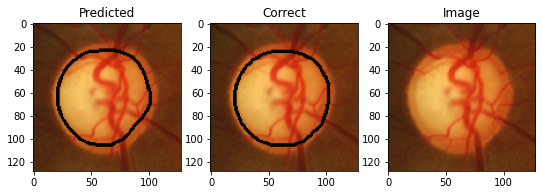

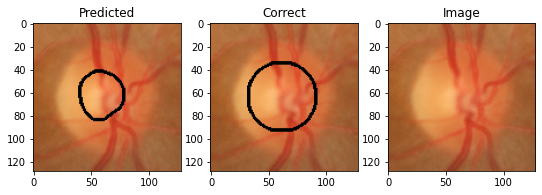

In [55]:
#%%time
pred_dice=np.empty((test_s), dtype=np.float32)
pred_iou=np.empty((test_s), dtype=np.float32)


#sess = K.get_session()

batch_X = X_test_dri[0:test_s]
batch_y = Y_test_dri[0:test_s]
print (batch_X.shape)
    
predv = (model.predict(batch_X,batch_size=test_s)[...,0]>0.5).astype(np.float32)
corrv= (batch_y)[ ..., 0].astype(np.float32)
predv1=predv.copy()

for i in tqdm_notebook(range(predv.shape[0])):
    #print('image #{}'.format(i))
    img = X_test_dri[i]
    
    pred = predv[i]
    corr = corrv[i]
    label_pc = skimage.measure.label(pred, connectivity=pred.ndim)
    props_pc = skimage.measure.regionprops(label_pc)
    sz=len(props_pc)
    if(sz)!=0:
      areap=[props_pc[i].area for i in range(sz)]
      k=np.argmax(areap)
      #print(k,areap)
      predv1[i]=np.equal(label_pc,k+1).astype(int).astype(np.float32)
    pred1= predv1[i]
    cur_dice = np_dice_coef(pred1, corr)
    cur_iou = np_iou(pred1,corr)
    #print(cur_dice)
    pred_dice[i]=(cur_dice)
    pred_iou[i]=cur_iou
    
    
d_worst=np.amin(pred_dice)
d_best=np.amax(pred_dice)
d_mean=np.mean(pred_dice)
d_std=np.std(pred_dice)
print("Dice mean=",d_mean, " Std=",d_std, " best=",d_best," worst=",d_worst)

i_worst=np.amin(pred_iou)
i_best=np.amax(pred_iou)
i_mean=np.mean(pred_iou)
i_std=np.std(pred_iou)
print("IOU mean=",i_mean, " Std=",i_std, " best=",i_best," worst=",i_worst)

ix_best=np.argmax(pred_dice)
ix_worst=np.argmin(pred_dice)

j=0
for i in [ix_best,ix_worst]:
    print('image #{}'.format(i))
    img = X_test_dri[i]
    pred = predv1[i]
    corr = corrv[i]
    
    print(pred_dice[i])
    fig = plt.figure(figsize=(9, 4))
    ax = fig.add_subplot(1, 3, 1)
    edgesp = canny(pred)
    edgesp=1.0-dilation(edgesp)
    edgesp = color.gray2rgb(1.0*edgesp)
    ax.imshow(img*edgesp)
    ax.set_title('Predicted')
    ax = fig.add_subplot(1, 3, 2)
    edgesc = canny(corr)
    edgesc=1.0-dilation(edgesc)
    edgesc = color.gray2rgb(1.0*edgesc)
    ax.imshow(img*edgesc)
    
    ax.set_title('Correct')
    ax = fig.add_subplot(1, 3, 3)
    #ax.imshow(img)
    ax.imshow(img)
    ax.set_title('Image')
    #plt.show()
    fig.savefig(os.path.join('/content/gdrive/My Drive/FIG','imgRIM'+str(j)+name+'.png'),dpi=600)
    j+=1
    


In [56]:
test_s=predv.shape[0]
cup_rr= np.empty((test_s), dtype=np.float32)
cup_dc= np.empty((test_s), dtype=np.float32)
cup_ac= np.empty((test_s), dtype=np.float32)
cup_ap= np.empty((test_s), dtype=np.float32)


predc = predv[0, ...].copy()
corrc= corrv[0, ...].copy()
print (predc.shape)

for i in tqdm_notebook(range(test_s), leave=True):
    
    predc = predv1[i]
    corrc = corrv[i]
    
    label_pc = skimage.measure.label(predc, connectivity=predc.ndim)
    props_pc = skimage.measure.regionprops(label_pc)
    
    label_cc = skimage.measure.label(corrc, connectivity=corrc.ndim)
    props_cc = skimage.measure.regionprops(label_cc)
    
    sz=len(props_pc)
    if(sz)!=0:
      areap=[props_pc[i].area for i in range(sz)]
      #print(sz,areap)
      k=np.argmax(areap)
    
      xcp = props_pc[k].centroid[0] #x center
      ycp = props_pc[k].centroid[1] #y_center
      ap = props_pc[k].area
    else:
      xpc=0
      ypc=0
      ac=0
    
    xcc = props_cc[0].centroid[0] #x center
    ycc = props_cc[0].centroid[1] #y_center
    ac = props_cc[0].area


    
    if (ap>ac):
      ar=ac/ap
    else:
      ar=ap/ac
      
    dist=math.sqrt((xcp-xcc)*(xcp-xcc)+(ycp-ycc)*(ycp-ycc))
    cup_rr[i]=math.sqrt(ar)
    cup_dc[i]=dist
    cup_ac[i]=ac
    cup_ap[i]=ap

(128, 128)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


In [57]:
print('Original preds')
print('best radii ratio= {:0.2f}, worst radii ratio= {:0.2f}, worst center distance= {:0.2f}, best center distance= {:0.2f}'.format(np.amax(cup_rr),np.amin(cup_rr),np.amax(cup_dc),np.amin(cup_dc)))
bt90=cup_rr>.85
print('Percentage of images with less than 15% radius error ={:0.2f}'.format(sum(bt90)/test_s))
bt90=cup_rr>.9
print('Percentage of images with less than 10% radius error ={:0.2f}'.format(sum(bt90)/test_s))

Original preds
best radii ratio= 1.00, worst radii ratio= 0.67, worst center distance= 7.84, best center distance= 0.62
Percentage of images with less than 15% radius error =0.85
Percentage of images with less than 10% radius error =0.62
